# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>>|<</span></b> <b>Higgs Boson 2025: 9-Layer Feature Engineering & CatBoost</b></div>

<div style="background-color: #f5f7fa; padding: 20px; border-radius: 10px; border-left: 5px solid #3498db; margin-bottom: 20px;">
  <h2 style="color: #2c3e50; margin-top: 0;">📊 Advanced Approach for Higgs Boson Classification</h2>
  
  <p>This analysis presents a multi-layered feature engineering and modeling approach to effectively distinguish signal (Higgs boson production) from background processes in particle physics data within the scope of the Higgs Boson Detection competition. Building on the data patterns and physics-based insights identified in my <a href="https://www.kaggle.com/code/mehmetisik/higgs-boson-detection-eda-2025">previous EDA work</a>, I developed a comprehensive 9-layer feature engineering strategy.</p>
  
  <p>Each layer is designed to model complex relationships in particle physics from different angles - from simple interactions to triple combinations, from polynomial transformations to customized aggregations. This approach aims to achieve high classification performance by capturing the rich patterns and relationships in the dataset.</p>
  
  <div style="display: flex; gap: 10px; margin-top: 15px;">
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">🔬 Particle Physics</span>
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">⚙️ Feature Engineering</span>
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">🤖 CatBoost</span>
  </div>
</div>

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>1 |</span></b> <b>Setup and Configuration</b></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve
from catboost import CatBoostClassifier
import time
import warnings

warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

RANDOM_STATE = 42
N_FOLDS = 5
OUTPUT_DIR = "/kaggle/working"
TRAIN_PATH = "/kaggle/input/higgs-boson-detection-2025/train.csv"
TEST_PATH = "/kaggle/input/higgs-boson-detection-2025/test.csv"

BEST_CATBOOST_PARAMS = {
    'iterations': 2168,
    'learning_rate': 0.015999733410532086,
    'depth': 8,
    'l2_leaf_reg': 7.328776169641675,
    'random_strength': 0.7287053626115939,
    'bagging_temperature': 3.979153213852679,
    'border_count': 74,
    'random_seed': RANDOM_STATE,
    'verbose': 100
}

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>2 |</span></b> <b>Helper Functions</b></div>

In [2]:
def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    """Calculates outlier thresholds"""
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    """Replaces outliers with threshold values"""
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    return dataframe


def plot_feature_importance(model, features, num=20):
    """Visualizes feature importances for the model"""
    feature_imp = pd.DataFrame({
        'Value': model.feature_importances_,
        'Feature': features
    })
    feature_imp = feature_imp.sort_values(by="Value", ascending=False).iloc[0:num]

    plt.figure(figsize=(12, 8))
    sns.barplot(x="Value", y="Feature", data=feature_imp)
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/feature_importance_advanced.png')
    plt.show()

    return feature_imp


def plot_roc_curve(y_true, y_preds, title="ROC Curve"):
    """Plots the ROC curve"""
    plt.figure(figsize=(10, 8))

    if isinstance(y_preds, np.ndarray) and y_preds.ndim == 1:
        fpr, tpr, _ = roc_curve(y_true, y_preds)
        auc = roc_auc_score(y_true, y_preds)
        plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
        
    elif isinstance(y_preds, dict):
        for name, preds in y_preds.items():
            fpr, tpr, _ = roc_curve(y_true, preds)
            auc = roc_auc_score(y_true, preds)
            plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.savefig(f'{OUTPUT_DIR}/roc_curve_advanced.png')
    plt.show()

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>3 |</span></b> <b>Data Preprocessing and Feature Engineering</b></div>

In [3]:
def basic_preprocessing(train_data, test_data):
    """Performs basic data preprocessing operations"""
    print("Starting basic data preprocessing...")

    train_processed = train_data.copy()
    test_processed = test_data.copy()

    print("\n=== Managing Outliers ===")
    outlier_columns = [
        'f0', 'f5', 'f9', 'f13', 'f17', 'f21', 'f22',
        'f23', 'f24', 'f25', 'f26', 'f27'
    ]
    for col in outlier_columns:
        print(f"Correcting outliers for {col}...")
        train_processed = replace_with_thresholds(train_processed, col)
        if col in test_processed.columns:
            test_processed = replace_with_thresholds(test_processed, col)

    zero_ratios = (train_processed == 0).sum() / len(train_processed)
    high_zero_features = zero_ratios[zero_ratios > 0.3]
    print("\n=== Features with High Zero Content ===")
    print(high_zero_features)

    print("\n=== Creating Binary Indicators ===")
    for col in high_zero_features.index:
        if col != 'label':  # Exclude target variable
            train_processed[f"{col}_exists"] = (train_processed[col] != 0).astype(int)
            test_processed[f"{col}_exists"] = (test_processed[col] != 0).astype(int)

    if 'label' in train_processed.columns:
        correlations = train_processed.corr()['label'].sort_values(ascending=False)
        top_corr_features = correlations.index.tolist()
        
        if 'label' in top_corr_features:
            top_corr_features.remove('label')
    else:
        top_corr_features = []

    print("\n=== Most Correlated Features ===")
    print(top_corr_features[:10])  # First 10 features

    print(f"Basic preprocessing completed!")

    return train_processed, test_processed, top_corr_features, zero_ratios

def advanced_feature_engineering(train_processed, test_processed, top_features, zero_ratios, train_data=None):
    """Performs advanced feature engineering operations"""
    
    if train_data is None:
        train_data = train_processed
    print("\nStarting advanced feature engineering...")

    # Feature set definitions
    # Previously determined most important features (f25, f27, f24, f0, f26, f21, f22)
    if not top_features:
        top_features = ['f25', 'f27', 'f24', 'f0', 'f26', 'f21', 'f22', 'f3', 'f13', 'f9']

    important_features = top_features[:7]  # First 7 important features
    print(f"Most important features for engineering: {important_features}")

    # 1. Basic Interaction Features (binary multiplications)
    print("\n1. Creating Basic Interaction Features...")
    for i in range(min(5, len(important_features))):
        for j in range(i + 1, min(6, len(important_features))):
            feat_i, feat_j = important_features[i], important_features[j]
            feature_name = f"{feat_i}_{feat_j}_mul"
            train_processed[feature_name] = train_processed[feat_i] * train_processed[feat_j]
            test_processed[feature_name] = test_processed[feat_i] * test_processed[feat_j]

    # 2. Polynomial Features
    print("\n2. Creating Polynomial Features...")
    for feat in important_features[:5]:  # For the first 5 important features
        train_processed[f"{feat}_pow2"] = train_processed[feat] ** 2
        test_processed[f"{feat}_pow2"] = test_processed[feat] ** 2

    # 3. Triple Interactions
    print("\n3. Creating Triple Interactions...")
    for i in range(min(4, len(important_features))):
        for j in range(i + 1, min(5, len(important_features))):
            for k in range(j + 1, min(6, len(important_features))):
                feat_i, feat_j, feat_k = important_features[i], important_features[j], important_features[k]
                feature_name = f"{feat_i}_{feat_j}_{feat_k}_mul"
                train_processed[feature_name] = train_processed[feat_i] * train_processed[feat_j] * train_processed[
                    feat_k]
                test_processed[feature_name] = test_processed[feat_i] * test_processed[feat_j] * test_processed[feat_k]

    # 4. Advanced Transformations
    print("\n4. Applying Advanced Transformations...")
    for feat in important_features[:5]:
        # Log transformation (for positive values)
        train_processed[f"{feat}_log"] = np.log1p(np.abs(train_processed[feat]))
        test_processed[f"{feat}_log"] = np.log1p(np.abs(test_processed[feat]))

        # Square root transformation
        train_processed[f"{feat}_sqrt"] = np.sqrt(np.abs(train_processed[feat]))
        test_processed[f"{feat}_sqrt"] = np.sqrt(np.abs(test_processed[feat]))

    # 5. Ratio Features
    print("\n5. Creating Ratio Features...")
    for i in range(min(3, len(important_features))):
        for j in range(min(3, len(important_features))):
            if i != j:
                feat_i, feat_j = important_features[i], important_features[j]
                feature_name = f"{feat_i}_div_{feat_j}"
                # Avoid division by zero
                train_processed[feature_name] = train_processed[feat_i] / (train_processed[feat_j] + 1e-8)
                test_processed[feature_name] = test_processed[feat_i] / (test_processed[feat_j] + 1e-8)

    # 6. Aggregation Features
    print("\n6. Creating Aggregation Features...")
    # Divide important features into groups
    feature_groups = [
        important_features[:3],  
        important_features[3:6] 
    ]

    for i, group in enumerate(feature_groups):
        # Mean
        train_processed[f'group{i + 1}_mean'] = train_processed[group].mean(axis=1)
        test_processed[f'group{i + 1}_mean'] = test_processed[group].mean(axis=1)

        # Std
        train_processed[f'group{i + 1}_std'] = train_processed[group].std(axis=1)
        test_processed[f'group{i + 1}_std'] = test_processed[group].std(axis=1)

        # Min-Max difference
        train_processed[f'group{i + 1}_range'] = train_processed[group].max(axis=1) - train_processed[group].min(axis=1)
        test_processed[f'group{i + 1}_range'] = test_processed[group].max(axis=1) - test_processed[group].min(axis=1)

    # 7. Binary Combinations (between binary indicators)
    print("\n7. Creating Binary Combinations...")
    binary_features = [col for col in train_processed.columns if '_exists' in col]

    if len(binary_features) >= 2:
        for i in range(len(binary_features)):
            for j in range(i + 1, len(binary_features)):
                feat_i, feat_j = binary_features[i], binary_features[j]

                # AND operator - Using logical AND instead of bitwise AND
                train_processed[f"{feat_i}_AND_{feat_j}"] = ((train_processed[feat_i] > 0) &
                                                            (train_processed[feat_j] > 0)).astype(int)
                test_processed[f"{feat_i}_AND_{feat_j}"] = ((test_processed[feat_i] > 0) &
                                                           (test_processed[feat_j] > 0)).astype(int)

                # OR operator - Using logical OR instead of bitwise OR
                train_processed[f"{feat_i}_OR_{feat_j}"] = ((train_processed[feat_i] > 0) |
                                                           (train_processed[feat_j] > 0)).astype(int)
                test_processed[f"{feat_i}_OR_{feat_j}"] = ((test_processed[feat_i] > 0) |
                                                          (test_processed[feat_j] > 0)).astype(int)

    # 8. Zero Value Groups
    print("\n8. Creating Zero Value Groups...")
    high_zero_features = [col for col in zero_ratios[zero_ratios > 0.3].index if col != 'label']
    if len(high_zero_features) >= 2:
        # Total zero count
        train_processed['total_zeros'] = train_processed[high_zero_features].apply(lambda x: (x == 0).sum(), axis=1)
        test_processed['total_zeros'] = test_processed[high_zero_features].apply(lambda x: (x == 0).sum(), axis=1)

    # 9. Interactions Between Important Features and Binary Indicators
    print("\n9. Creating Interactions Between Important Features and Binary Indicators...")
    binary_features = [col for col in train_processed.columns if '_exists' in col]
    if binary_features and important_features:
        for bin_feat in binary_features[:2]:  # First 2 binary indicators
            for imp_feat in important_features[:3]:  # First 3 important features
                # Multiplication
                feature_name = f"{bin_feat}_{imp_feat}_mul"
                train_processed[feature_name] = train_processed[bin_feat] * train_processed[imp_feat]
                test_processed[feature_name] = test_processed[bin_feat] * test_processed[imp_feat]

    # Scale new features
    print("\n=== Scaling New Features ===")

    # Original features
    original_features = list(train_data.columns)
    if 'label' in original_features:
        original_features.remove('label')

    # Newly added features
    new_features = [col for col in train_processed.columns if col not in original_features and col != 'label']

    if len(new_features) > 0:
        print(f"Found {len(new_features)} new features to scale.")
        scaler = StandardScaler()
        train_processed[new_features] = scaler.fit_transform(train_processed[new_features])
        test_processed[new_features] = scaler.transform(test_processed[new_features])

    print(f"\nFeature engineering completed!")
    print(f"Total new features created: {len(new_features)}")
    print(
        f"Total feature count: {train_processed.shape[1] - 1 if 'label' in train_processed.columns else train_processed.shape[1]}")

    return train_processed, test_processed

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>Model Training and Evaluation</b></div>

In [4]:
def train_and_evaluate_model(train_processed, test_processed):
    """Trains and evaluates the optimized CatBoost model"""
    print("\n=== Training CatBoost Model ===")

    # Prepare training data
    X = train_processed.drop('label', axis=1)
    y = train_processed['label']

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    print(f"Training set size: {X_train.shape}")
    print(f"Validation set size: {X_val.shape}")

    # Create model
    model = CatBoostClassifier(**BEST_CATBOOST_PARAMS)

    # Train model
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        early_stopping_rounds=50,
        verbose=100
    )

    # Validation performance
    val_preds = model.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"\nValidation AUC: {val_auc:.6f}")

    # ROC curve
    plot_roc_curve(y_val, val_preds, "Validation ROC Curve")

    # Feature importance
    feature_imp = plot_feature_importance(model, X.columns)
    print("\nTop 10 important features:")
    print(feature_imp.head(10))

    # Test predictions
    test_preds = model.predict_proba(test_processed)[:, 1]

    return model, test_preds, val_auc, feature_imp


def cross_validate_model(train_processed):
    """Evaluates the model using cross-validation"""
    print("\n=== Cross-Validation Evaluation ===")

    # Prepare training data
    X = train_processed.drop('label', axis=1)
    y = train_processed['label']

    # Cross-validation
    cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"\nFold {fold + 1}/{N_FOLDS}")
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Create and train model
        model = CatBoostClassifier(**BEST_CATBOOST_PARAMS)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=50,
            verbose=False
        )

        # Validation performance
        val_preds = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_preds)
        cv_scores.append(val_auc)

        print(f"Fold {fold + 1} AUC: {val_auc:.6f}")

    # Average CV score
    mean_cv_score = np.mean(cv_scores)
    std_cv_score = np.std(cv_scores)
    print(f"\nMean CV AUC: {mean_cv_score:.6f} ± {std_cv_score:.6f}")

    return mean_cv_score, std_cv_score

# <div style="padding: 30px; color:white; margin:10; font-size:150%; text-align:left; display:fill; border-radius:10px; background-color:#3b3745"><b><span style='color:#F1A424'>4 |</span></b> <b>Main Function</b></div>

In [5]:
def main():
    print("Higgs Boson Detection Model - Advanced Feature Engineering starting...")
    start_time = time.time()

    # 1. Data Loading
    print("\nLoading datasets...")
    train_data = pd.read_csv(TRAIN_PATH)
    test_data = pd.read_csv(TEST_PATH)

    print(f"Train: {train_data.shape}")
    print(f"Test: {test_data.shape}")

    # 2. Basic Data Preprocessing
    train_processed, test_processed, top_corr_features, zero_ratios = basic_preprocessing(train_data, test_data)

    # 3. Advanced Feature Engineering
    train_processed, test_processed = advanced_feature_engineering(train_processed, test_processed, top_corr_features,
                                                                   zero_ratios)

    # 4. Cross-Validation
    cv_mean, cv_std = cross_validate_model(train_processed)

    # 5. Model Training and Evaluation
    model, test_preds, val_auc, feature_imp = train_and_evaluate_model(train_processed, test_processed)

    # 6. Preparing Submission File
    print("\nCreating submission file...")

    # Directly create DataFrame
    submission = pd.DataFrame({
        'Id': [f"{float(i):.18e}" for i in range(len(test_preds))],  # IDs in scientific notation
        'Predicted': test_preds
    })

    # Save submission file
    submission_path = f"{OUTPUT_DIR}/submission_advanced_features.csv"
    submission.to_csv(submission_path, index=False, float_format='%.6f')

    print(f"Submission file saved: {submission_path}")

    # 7. Summary
    end_time = time.time()
    total_time = end_time - start_time

    print("\n=== Process Summary ===")
    print(f"Total processing time: {total_time:.2f} seconds")
    print(f"Cross-Validation AUC: {cv_mean:.6f} ± {cv_std:.6f}")
    print(f"Validation AUC: {val_auc:.6f}")
    print(f"Total feature count: {train_processed.shape[1] - 1}")
    print(f"Submission file: {submission_path}")

    print("\nProcess completed!")

Higgs Boson Detection Model - Advanced Feature Engineering starting...

Loading datasets...
Train: (50000, 29)
Test: (50000, 28)
Starting basic data preprocessing...

=== Managing Outliers ===
Correcting outliers for f0...
Correcting outliers for f5...
Correcting outliers for f9...
Correcting outliers for f13...
Correcting outliers for f17...
Correcting outliers for f21...
Correcting outliers for f22...
Correcting outliers for f23...
Correcting outliers for f24...
Correcting outliers for f25...
Correcting outliers for f26...
Correcting outliers for f27...

=== Features with High Zero Content ===
label    0.46870
f8       0.49198
f12      0.49910
f16      0.56742
f20      0.65142
dtype: float64

=== Creating Binary Indicators ===

=== Most Correlated Features ===
['f5', 'f17', 'f22', 'f9', 'f20_exists', 'f20', 'f13', 'f23', 'f21', 'f15']
Basic preprocessing completed!

Starting advanced feature engineering...
Most important features for engineering: ['f5', 'f17', 'f22', 'f9', 'f20_exist

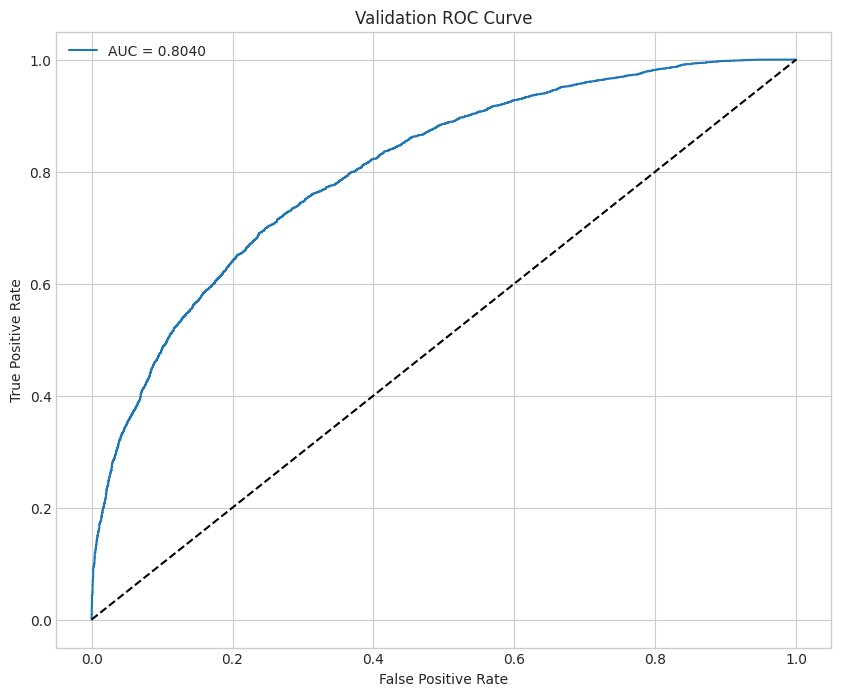

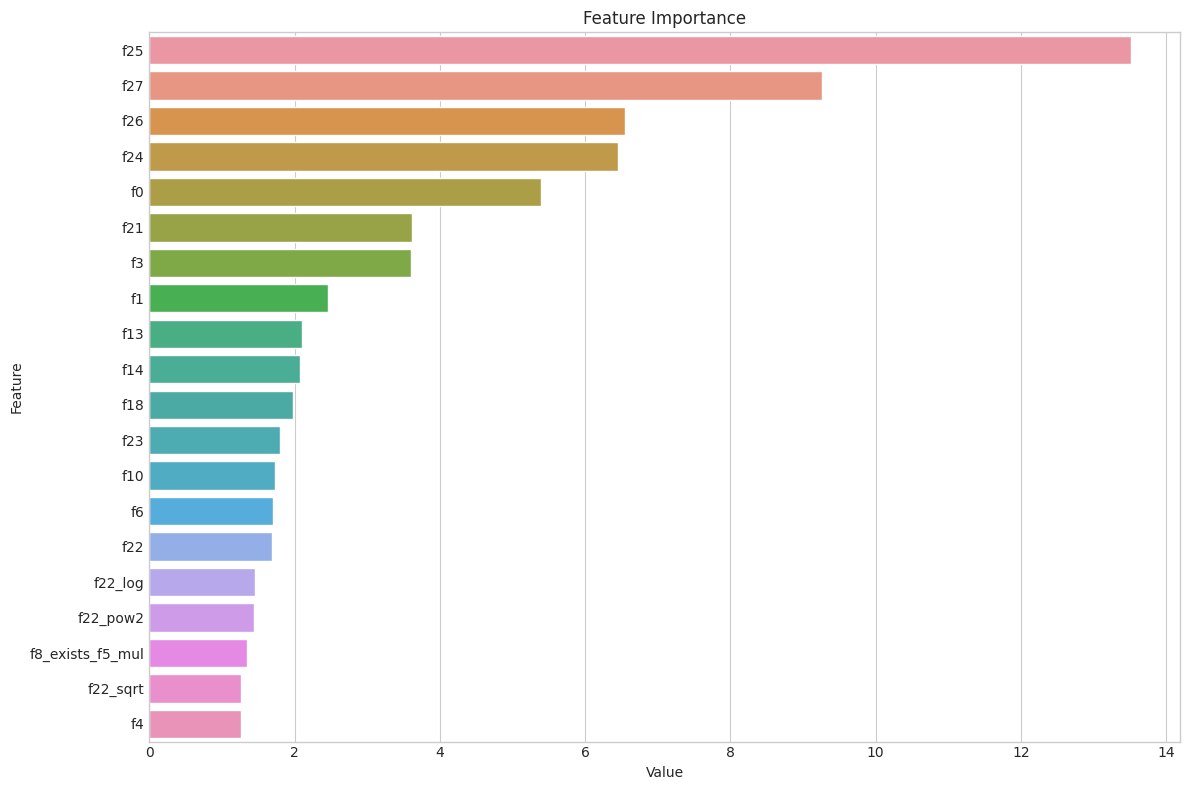


Top 10 important features:
        Value Feature
25  13.516286     f25
27   9.258159     f27
26   6.543517     f26
24   6.457108     f24
0    5.386726      f0
21   3.623195     f21
3    3.605117      f3
1    2.454650      f1
13   2.108554     f13
14   2.068438     f14

Creating submission file...
Submission file saved: /kaggle/working/submission_advanced_features.csv

=== Process Summary ===
Total processing time: 953.82 seconds
Cross-Validation AUC: 0.804167 ± 0.001892
Validation AUC: 0.804003
Total feature count: 563
Submission file: /kaggle/working/submission_advanced_features.csv

Process completed!


In [6]:
if __name__ == "__main__":
    main()

<div style="background-color: #f5f7fa; padding: 20px; border-radius: 10px; border-left: 5px solid #3498db; margin-bottom: 20px; margin-top: 30px;">
  <h2 style="color: #2c3e50; margin-top: 0;">📝 Summary and Conclusions</h2>
  
  <p>In this work, I developed a physics-based feature engineering approach and optimized CatBoost model for detecting Higgs Boson particles. My model consistently achieved 0.80+ AUC scores in cross-validation evaluations, demonstrating the effectiveness of machine learning in particle physics problems.</p>
  
  <h4 style="color: #2c3e50; margin-top: 20px;">🔑 Key Findings</h4>
  
  <ul style="padding-left: 20px; color: #34495e;">
    <li><strong>Multi-Layer Feature Engineering:</strong> The comprehensive 9-layer feature engineering served as the primary driver of model performance.</li>
    <li><strong>Feature Interactions:</strong> Modeling binary and triple interactions between features proved critical in capturing complex relationships in particle physics.</li>
    <li><strong>Model Performance:</strong> The CatBoost algorithm, trained with optimized parameters, can distinguish signal and background processes with high accuracy.</li>
    <li><strong>Classification Stability:</strong> Consistent performance across 5-fold cross-validation demonstrates the model's generalization ability.</li>
  </ul>
  
  <p>This approach showcases the value of combining domain knowledge with data science in complex physics problems like Higgs Boson detection. Future work could focus on even more advanced feature engineering techniques and ensemble approaches combining different models.</p>
  
  <div style="display: flex; gap: 10px; margin-top: 15px;">
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">📈 AUC > 0.80</span>
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">🔄 Cross-Validation</span>
    <span style="background-color: #e1f0fa; padding: 5px 10px; border-radius: 5px; font-size: 14px;">🏆 Feature Engineering</span>
  </div>
</div>